In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt

from world import World
from utils import  getpolicy, getvalue, plotarrows

plt.rcParams['figure.facecolor']='white'

In [2]:
world1 = World(1)

In [3]:
world1.feed

array([[-0.1 , -0.1 , -0.1 , -0.1 , -2.32, -2.32, -2.32, -2.32, -0.1 ,
        -0.1 , -0.1 , -0.1 , -0.1 , -0.1 , -0.1 ],
       [-0.1 , -0.1 , -0.1 , -0.1 , -2.32, -2.32, -2.32, -2.32, -0.1 ,
        -0.1 , -0.1 , -0.1 , -0.1 , -0.1 , -0.1 ],
       [-0.1 , -0.1 , -0.1 , -0.1 , -2.32, -2.32, -2.32, -2.32, -0.1 ,
        -0.1 , -0.1 , -0.1 , -0.1 , -0.1 , -0.1 ],
       [-0.1 , -0.1 , -0.1 , -0.1 , -2.32, -2.32, -2.32, -2.32, -0.1 ,
        -0.1 , -0.1 , -0.1 , -0.1 , -0.1 , -0.1 ],
       [-0.1 , -0.1 , -0.1 , -0.1 , -2.32, -2.32, -2.32, -2.32, -0.1 ,
        -0.1 , -0.1 , -0.1 , -0.1 , -0.1 , -0.1 ],
       [-0.1 , -0.1 , -0.1 , -0.1 , -2.32, -2.32, -2.32, -2.32, -0.1 ,
        -0.1 , -0.1 , -0.1 , -0.1 , -0.1 , -0.1 ],
       [-0.1 , -0.1 , -0.1 , -0.1 , -2.32, -2.32, -2.32, -2.32, -0.1 ,
        -0.1 , -0.1 , -0.1 , -0.1 , -0.1 , -0.1 ],
       [-0.1 , -0.1 , -0.1 , -0.1 , -2.32, -2.32, -2.32, -2.32, -0.1 ,
        -0.1 , -0.1 , -0.1 , -0.1 , -0.1 , -0.1 ],
       [-0.1 , -0.1 , -0

In [4]:
world1.pos

(1, 1)

In [5]:
curr_state = world1.term

In [6]:
world1.action(3)

(1, -0.1)

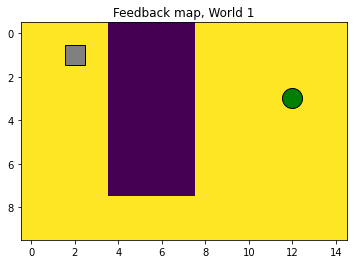

In [7]:
world1.draw()

In [8]:
q = np.zeros((1,4))

In [9]:
for i in range(1,5):
    world1.action(i)
    new_state = world1.term
    q_table[new_state[0]:i+1] = world1.feed[new_state]

NameError: name 'q_table' is not defined

In [10]:
world1.action(getvalue(q))

TypeError: only size-1 arrays can be converted to Python scalars

In [11]:
world1.feed.shape[0]

10

In [12]:
# Initialization
# Initialize the world, Q-table, and hyperparameters
world1 = World(1)
q_table = np.zeros((world1.y_size, world1.x_size,4))
#q_table.hstack()    
learning_rate = 0.01
discount = 0.99
episodes = 5
epsilon = 0.9
start_epsilon_decaying = 1
end_epsilon_decaying = episodes//2
epsilon_decay_value = epsilon/(end_epsilon_decaying - start_epsilon_decaying)

In [13]:
world1.action(4)
        

(1, -0.1)

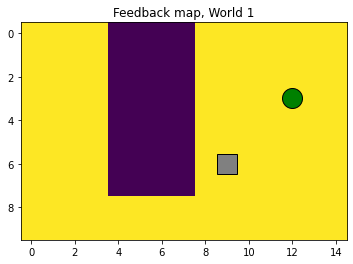

In [14]:
world1.draw()

In [15]:
world1.term

(3, 12)

In [16]:
np.argmax(q_table[(8,8)], axis=0)

0

In [17]:
world1.pos

(6, 9)

In [18]:
act = getvalue(q_table[current_state])
act

NameError: name 'current_state' is not defined

In [19]:
world1.action(act)

NameError: name 'act' is not defined

In [21]:
# Initialization
# Initialize the world, Q-table, and hyperparameters
world1 = World(1)
q_table = np.zeros((world1.y_size, world1.x_size,4))
#q_table.hstack()    
learning_rate = 0.01
discount = 0.95
episodes = 1000
epsilon = 0.9
start_epsilon_decaying = 1
end_epsilon_decaying = episodes//2
epsilon_decay_value = epsilon/(end_epsilon_decaying - start_epsilon_decaying)

(0, 14)
1
1 -0.1


KeyboardInterrupt: 

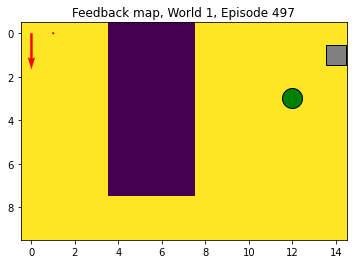

In [22]:
# Training loop
# Train the agent using the Q-learning algorithm.

# act 1 -> bottom
# act 2 -> top
# act 3 -> right
# act 4 -> left

import random
for episode in range(episodes):
    
    world = World(1)
    
    done = False
    current_state = world.pos
    print(current_state)
    #print(world1.draw())
    while not done:
        
        if np.random.random() >epsilon:
            act = getvalue(q_table[current_state])
        else:
            act = np.random.choice([1,2,3,4])
        if current_state[1] == 14:
            act = random.choice([2,4])
        if current_state[0] == 9:
            act = random.choice([2,3])
        if current_state[0] == 0:
            act = random.choice([1,3])
        if current_state[1] == 0:
            act = random.choice([2,3])
        if current_state[0] == 0 and current_state[1] ==14:
            act = random.choice([1,4])
        if current_state[0] == 9 and current_state[1] ==0:
            act = random.choice([2,3])
        if current_state[0] == 0 and current_state[1] ==0:
            act = random.choice([1,3])
        if current_state[0] == 9 and current_state[1] ==14:
            act = random.choice([2,4])
        print(act)
        value, reward = world.action(act)
        
        print(value,reward)
        new_state = world.pos
        
        world.draw(episode=episode, policy=np.array(list(current_state)).reshape((1,2)))
        print(new_state)
        
        if new_state == world.term:
            q_table[current_state + (act-1,)] = 0
            done= True
            print(f'We have made it to episode {episode}')
            
        
        elif not done:
            max_future_q = getpolicy(q_table[new_state])
            current_q = getpolicy(q_table[current_state + (act-1,)])


            new_q = (1-learning_rate) * current_q + learning_rate*(reward + discount*max_future_q)
            q_table[current_state + (act-1,)] = new_q


        
            
        current_state = new_state
        
    if end_epsilon_decaying >= episode >= start_epsilon_decaying:
        epsilon -= epsilon_decay_value

In [417]:
np.array(list((1,3))).shape

(2,)

In [32]:
np.array(list(current_state)).reshape((1,2))

array([[ 3, 12]])

In [25]:
epsilon

0.005410821643290457

In [24]:
q_table

array([[[-5.95268027e-02,  0.00000000e+00, -6.07288972e-02,
          0.00000000e+00],
        [-1.21104265e-01,  0.00000000e+00, -7.23748332e-02,
          0.00000000e+00],
        [-1.26281412e-01,  0.00000000e+00, -8.03708486e-02,
          0.00000000e+00],
        [-1.59415374e-01,  0.00000000e+00, -2.11414099e+00,
          0.00000000e+00],
        [-1.63148580e+00,  0.00000000e+00, -1.81645584e+00,
          0.00000000e+00],
        [-2.13955040e+00,  0.00000000e+00, -1.44481098e+00,
          0.00000000e+00],
        [-1.37138058e+00,  0.00000000e+00, -1.30240740e+00,
          0.00000000e+00],
        [-1.03037075e+00,  0.00000000e+00, -4.18833586e-02,
          0.00000000e+00],
        [-9.63062467e-02,  0.00000000e+00, -6.68966912e-02,
          0.00000000e+00],
        [-1.01586395e-01,  0.00000000e+00, -7.09511506e-02,
          0.00000000e+00],
        [-9.17957010e-02,  0.00000000e+00, -7.34633750e-02,
          0.00000000e+00],
        [-1.00660969e-01,  0.00000000e+00, 

In [ ]:
# Test loop
# Test the agent (subjectively) by letting it use the optimal policy to traverse the gridworld.
# Do not update the Q-table when testing.
# Also, you should not explore when testing, i.e. epsilon=0; always pick the optimal action.

